In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import coo_matrix
import xgboost as xgb
from sklearn.model_selection import cross_val_score

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_json('./rVG5.json', lines=True)
df = df.sample(frac=1, random_state=111)

In [3]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
133556,B002FQM5OG,"[0, 0]",2,"Even though I've had this kit for awhile, it d...","03 28, 2010",AKCZIJ6ZHE41D,"Jarucia Jaycox ""~A Pink American""",Not so Good Drum Kit,1269734400
211868,B009CCTSIM,"[1, 1]",5,This thing is long enough to comfortably play ...,"01 24, 2013",A1OXMAQIY6JUI9,J. Thompson,It's a piece of stretched copper... IT WORKS,1358985600
195170,B006BEZQRG,"[3, 9]",3,"My son really enjoyed the game, it worked well...","03 28, 2012",A31IF5TD2TMSH3,Heather Brown,Good But Pricey,1332892800
52069,B0006B0O9U,"[3, 3]",4,I really enjoyed this game! There are many di...,"11 20, 2005",A1I1SYNU6R6XGP,"Fluffychicken ""The almighty overlord""",Very Good,1132444800
223484,B00CYNTHA0,"[1, 2]",1,This game looks alright. Some aspects of the ...,"06 12, 2014",A26MZ8J9S58O57,johnthejanitor,Blows,1402531200


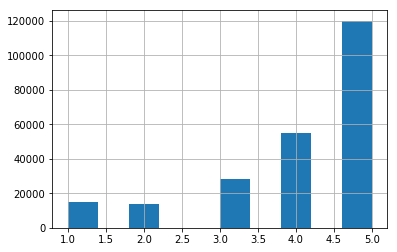

In [4]:
df.overall.hist();
plt.show();

In [5]:
df[df.overall==4].iloc[7].reviewText

"I'm not sure which one I like more, this game or Yoshi's Cookie. Both have different rules of gameplay, but both are also challenging. I've always been a sucker for Tetris-style games (pieces fall down, you try to get rid of them) For a NES game, the controls and graphics were smooth. There's not much I can say that other reviewers haven't already said. If you like puzzle games, you should enjoy this."

In [6]:
df['pos'] = np.where(df.overall > 2, 1, 0)
class_imb = 1-(df.pos.sum()/len(df))
print(class_imb)

0.123030459919


In [7]:
df['reviewText'] = df.reviewText.str.lower()

In [8]:
tv = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', min_df=.00001, max_df=.9)
tv.fit(df.reviewText)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=1e-05,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

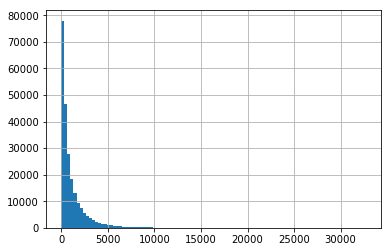

In [9]:
df['reviewText'] = df.reviewText.str.lower()
df['review_length'] = df.reviewText.apply(len)
def match_string(keystring, desc):
    result = 0
    if keystring in desc:
        result = 1
    return result
df['helpful_clicks'] = df.helpful.apply(lambda x: x[1])
def get_help_rating(helpful):
    if helpful[1] == 0:
        return 0
    elif helpful[1] > 0:
        return helpful[0]/helpful[1]
df['helpful_rating'] = df.helpful.apply(get_help_rating)
df['summary_length'] = df.summary.apply(len)

df.review_length.hist(bins=100)
plt.show();

In [10]:
features = tv.transform(df.reviewText)
features

<231780x1192329 sparse matrix of type '<class 'numpy.float64'>'
	with 30091877 stored elements in Compressed Sparse Row format>

In [11]:
cutoff = int(.8 * len(df))

ft = [
    'review_length',
    'helpful_clicks',
    'helpful_rating',
    'summary_length'
]


train = df[:cutoff]
ft_train = scipy.sparse.hstack((features[:cutoff], np.array(df[ft][:cutoff])))

test = df[cutoff:]
ft_test = scipy.sparse.hstack((features[cutoff:], np.array(df[ft][cutoff:])))


Y_train = train.pos
Y_test = test.pos

In [12]:
ft_test

<46356x1192333 sparse matrix of type '<class 'numpy.float64'>'
	with 6174739 stored elements in COOrdinate format>

In [13]:
dtrain = xgb.DMatrix(ft_train, label=Y_train)
dtest = xgb.DMatrix(ft_test, label=Y_test)
param = {
    'max_depth': 7, 
    'eta': 1, 
    'silent': 0, 
    'objective': 
    'binary:logistic', 
    'scale_pos_weight': (class_imb),
    'nthread':4,
    'eval_metric':'auc'
}

plst = param.items()
num_round = 500
bst = xgb.train(plst, dtrain, num_round)

Y_ = np.where(bst.predict(dtrain)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_train)
print(tb)
print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

Y_ = np.where(bst.predict(dtest)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_test)
print(tb)
print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

KeyboardInterrupt: 

In [ ]:
dtrain = xgb.DMatrix(ft_train, label=Y_train)
dtest = xgb.DMatrix(ft_test, label=Y_test)
param = {
    'max_depth': 7, 
    'eta': 1, 
    'silent': 0, 
    'objective': 
    'binary:logistic', 
    'scale_pos_weight': (class_imb),
    'nthread':4,
    'eval_metric':'auc'
}

plst = param.items()
num_round = 1000
bst = xgb.train(plst, dtrain, num_round)

Y_ = np.where(bst.predict(dtrain)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_train)
print(tb)
print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

Y_ = np.where(bst.predict(dtest)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_test)
print(tb)
print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

0.87677970489257051

In [ ]:
def print_model_results(dpth=3, eta=.1, n_estimators=100, cst=1):
    dtrain = xgb.DMatrix(ft_train, label=Y_train)
    dtest = xgb.DMatrix(ft_test, label=Y_test)
    param = {
        'max_depth': dpth, 
        'eta': eta, 
        'silent': 0,
        'objective' : 'binary:logistic', 
        'scale_pos_weight': (class_imb),
        'nthread':4,
        'eval_metric':'auc',
        'colsample_bytree': cst
    }

    plst = param.items()
    num_round = n_estimators
    bst = xgb.train(plst, dtrain, num_round)

    Y_ = np.where(bst.predict(dtrain)>.5, 1, 0)
    tb = pd.crosstab(Y_, Y_train)
    print(tb)
    print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

    Y_ = np.where(bst.predict(dtest)>.5, 1, 0)
    tb = pd.crosstab(Y_, Y_test)
    print(tb)
    print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())
    
print_model_results(n_estimators=1000, eta=.2, dpth=6, cst=1)

In [ ]:
def record_model_results(results, dpth=3, eta=.1, n_estimators=100, cst=1):
    dtrain = xgb.DMatrix(ft_train, label=Y_train)
    dtest = xgb.DMatrix(ft_test, label=Y_test)
    param = {
        'max_depth': dpth, 
        'eta': eta, 
        'silent': 0,
        'objective' : 'binary:logistic', 
        'scale_pos_weight': (class_imb),
        'nthread':4,
        'eval_metric':'auc',
        'colsample_bytree': cst
    }

    plst = param.items()
    num_round = n_estimators
    bst = xgb.train(plst, dtrain, num_round)

    Y_tr = np.where(bst.predict(dtrain)>.5, 1, 0)
    tb_train = pd.crosstab(Y_tr, Y_train)

    Y_te = np.where(bst.predict(dtest)>.5, 1, 0)
    tb_test = pd.crosstab(Y_te, Y_test)
    next_row = pd.DataFrame(columns=results.columns, index=[len(results)])
    next_row['n_estimators'] = num_round
    next_row['params'] = [param]
    if len(tb_train) == 2:
        next_row['train_tab'] = [tb_train]
        next_row['train_acc'] = (tb_train.iloc[0, 0]+tb_train.iloc[1, 1])/tb_train.sum().sum()
    else:
        next_row['train_tab'] = [tb_train]
        next_row['train_acc'] = tb_train.iloc[0, 1]/tb_train.sum()
    if len(tb_test) == 2:
        next_row['test_tab'] = [tb_test]
        next_row['test_acc'] = (tb_test.iloc[0, 0]+tb_test.iloc[1, 1])/tb_test.sum().sum()
    else:
        next_row['test_tab'] = [tb_test]
        next_row['test_acc'] = tb_test.iloc[0, 1]/tb_test.sum()
    results = pd.concat([results, next_row], axis=0)
    return results

In [ ]:
cols = [
    'params',
    'n_estimators',
    'train_tab',
    'train_acc',
    'test_tab',
    'test_acc'
]

results = pd.DataFrame(columns=cols)

In [ ]:
itt = 0
while itt < 1:
    n = 1000
    eta = np.random.random_sample()
    dp = int(np.random.random_sample()*30)
    cst = (np.random.random_sample() * (.7)) + .3
    itt += 1
    cst = cst/10
    results = record_model_results(results, dpth=dp, eta=eta, n_estimators=n, cst=cst)
    print('round number: ', itt)
    print('test accuracy: ', results.iloc[-1].test_acc)

In [ ]:
results.loc[results.test_acc.idxmax()].test_acc

In [ ]:
cvc = cross_val_score()